In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img


Using TensorFlow backend.


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
##import tensorflow_federated as tff
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from tensorflow import keras
from skimage.transform import resize
from keras.preprocessing.image import load_img
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import flwr as fl

In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
#from tqdm.notebook import tqdm
def get_img_dataset(image_dir,mask_dir, max_=255.0):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

    train_df1 = pd.DataFrame({
        'image_paths': image_files,
        'mask_paths': mask_files
    })
    train_df1["images"] = [
        np.array(load_img(img_path, color_mode = "grayscale")) / max_ for img_path in tqdm_notebook(train_df1["image_paths"])
    ]
    train_df1["masks"] = [
        (np.array(load_img(mask_path, color_mode="grayscale")) > 0).astype(np.float32) for mask_path in tqdm_notebook(train_df1["mask_paths"])
    ]

    return train_df1


In [5]:
image_dir = "/kaggle/input/tgs-train-test/train-tgs/images"
mask_dir = "/kaggle/input/tgs-train-test/train-tgs/masks"
train_df1 = get_img_dataset(image_dir,mask_dir
                           )
image_dir = "/kaggle/input/seam11/images"
mask_dir = "/kaggle/input/seam11/masks"
train_df2 = get_img_dataset(image_dir,mask_dir)

image_dir = "/kaggle/input/f3-train/images"
mask_dir = "/kaggle/input/f3-train/masks"
train_df3 = get_img_dataset(image_dir,mask_dir)

In [6]:
# Define bin edges and labels
bin_edges = np.linspace(0, 1, 11)  # Divide the range [0, 1] into 10 equal bins
bin_labels = list(range(10))  # Labels for the bins (0 to 9)

# Calculate the coverage
train_df1["coverage"] = train_df1.masks.map(np.sum) / pow(img_size_ori, 2)

# Use pd.cut to assign coverage_class
train_df1["coverage_class"] = pd.cut(
    train_df1["coverage"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

In [7]:
# Define bin edges and labels
bin_edges = np.linspace(0, 1, 11)  # Divide the range [0, 1] into 10 equal bins
bin_labels = list(range(10))  # Labels for the bins (0 to 9)

# Calculate the coverage
train_df2["coverage"] = train_df2.masks.map(np.sum) / pow(img_size_ori, 2)

# Use pd.cut to assign coverage_class
train_df2["coverage_class"] = pd.cut(
    train_df2["coverage"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)


In [8]:
# Define bin edges and labels
bin_edges = np.linspace(0, 1, 11)  # Divide the range [0, 1] into 10 equal bins
bin_labels = list(range(10))  # Labels for the bins (0 to 9)

# Calculate the coverage
train_df3["coverage"] = train_df3.masks.map(np.sum) / pow(img_size_ori, 2)

# Use pd.cut to assign coverage_class
train_df3["coverage_class"] = pd.cut(
    train_df3["coverage"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)


In [9]:
train_df11, valid_df1 = train_test_split(train_df1, test_size=0.20, stratify=train_df1.coverage_class, random_state=31)
train_df22, valid_df2 = train_test_split(train_df2, test_size=0.20, stratify=train_df2.coverage_class, random_state=31)
train_df33, valid_df3 = train_test_split(train_df3, test_size=0.20, stratify=train_df3.coverage_class, random_state=31)

In [10]:
train_df = pd.concat([train_df11,train_df22,train_df33])
valid_df = pd.concat([valid_df1,valid_df2,valid_df3])

In [11]:
x_train = np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train = np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
#x_train1 = np.repeat(x_train1, 3, axis=-1)
#y_train1 = np.repeat(y_train1, 3, axis=-1)

In [12]:
x_valid = np.array(valid_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid = np.array(valid_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
#x_valid1 = np.repeat(y_valid1, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [13]:
def calculate_foreground_percentage(masks_array, img_size_ori):
    """
    Calculates the total percentage of foreground and background pixels across all masks.

    Args:
        masks_array: A NumPy array of binary masks.
        img_size_ori: The original size of the images.

    Returns:
        A tuple containing (total_foreground_percentage, total_background_percentage).
    """
    total_pixels_all_images = len(masks_array) * (img_size_ori * img_size_ori)
    total_foreground_pixels = np.sum(masks_array)
    total_background_pixels = total_pixels_all_images - total_foreground_pixels

    total_foreground_percentage = (total_foreground_pixels / total_pixels_all_images) * 100
    total_background_percentage = (total_background_pixels / total_pixels_all_images) * 100

    return total_foreground_pixels / total_pixels_all_images

In [68]:
calculate_total_foreground_background_percentage(y_train1, 128)

0.2480938855339499

In [90]:
x_train1 = np.array(train_df11.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train1 = np.array(train_df11.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
#x_train1 = np.repeat(x_train1, 3, axis=-1)
#y_train1 = np.repeat(y_train1, 3, axis=-1)

In [11]:
x_valid1 = np.array(valid_df1.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid1 = np.array(valid_df1.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_valid1 = np.repeat(y_valid1, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [12]:
x_valid2 = np.array(valid_df2.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#y_valid2 = np.array(valid_df2.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
x_valid2 = np.repeat(y_valid1, 3, axis=-1)
#y_valid1 = np.repeat(y_train1, 3, axis=-1)

In [91]:
x_train2 = np.array(train_df22.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train2 = np.array(train_df22.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
#x_train2 = np.repeat(x_train2, 3, axis=-1)
#y_train2 = np.repeat(y_train2, 3, axis=-1)

In [92]:
x_train3 = np.array(train_df33.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_train3 = np.array(train_df33.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
#Transforming to 3 channels to match the model dimensions
#x_train3 = np.repeat(x_train3, 3, axis=-1)
#y_train3 = np.repeat(y_train3, 3, axis=-1)

In [17]:
x_train1.shape

(2720, 128, 128, 1)

# Simple U-Net

In [14]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


In [15]:
# Build model 128
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    #conv1 = residual_block(conv1,start_neurons * 1)
    #conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    #conv2 = residual_block(conv2,start_neurons * 2)
    #conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    #conv3 = residual_block(conv3,start_neurons * 4)
    #conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    #convm = residual_block(convm,start_neurons * 16)
    #convm = residual_block(convm,start_neurons * 16, True)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    #uconv4 = residual_block(uconv4,start_neurons * 8)
    #uconv4 = residual_block(uconv4,start_neurons * 8, True)

    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    #uconv3 = residual_block(uconv3,start_neurons * 4)
    #uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    #uconv2 = residual_block(uconv2,start_neurons * 2)
    #uconv2 = residual_block(uconv2,start_neurons * 2, True)

    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])

    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    #uconv1 = residual_block(uconv1,start_neurons * 1)
    #uconv1 = residual_block(uconv1,start_neurons * 1, True)

    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)

    return output_layer

In [16]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [17]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

# Define a hybrid loss function
def hybrid_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    lovasz = lovasz_loss(y_true, y_pred)
    return bce_loss + lovasz

In [18]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [19]:
from keras.legacy import interfaces
from keras.optimizers import SGD
from keras.utils.generic_utils import get_custom_objects
def l2_norm(grad):
    norm = K.sqrt(K.sum(K.square(grad))) + K.epsilon()
    return norm

class OptimizerWrapper(optimizers.Optimizer):

    def __init__(self, optimizer):     
        
        self.optimizer = optimizers.get(optimizer)

        # patch the `get_gradients` call
        self._optimizer_get_gradients = self.optimizer.get_gradients

    def get_gradients(self, loss, params):      
        grads = self._optimizer_get_gradients(loss, params)
        return grads

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        # monkey patch `get_gradients`
        self.optimizer.get_gradients = self.get_gradients

        # get the updates
        self.optimizer.get_updates(loss, params)

        # undo monkey patch
        self.optimizer.get_gradients = self._optimizer_get_gradients

        return self.updates

    def set_weights(self, weights):       
        self.optimizer.set_weights(weights)

    def get_weights(self):        
        return self.optimizer.get_weights()

    def get_config(self):       
        # properties of NormalizedOptimizer
        config = {'optimizer_name': self.optimizer.__class__.__name__.lower()}

        # optimizer config
        optimizer_config = {'optimizer_config': self.optimizer.get_config()}
        return dict(list(optimizer_config.items()) + list(config.items()))

    @property
    def weights(self):
        return self.optimizer.weights

    @property
    def updates(self):
        return self.optimizer.updates

    @classmethod
    def from_config(cls, config):
        raise NotImplementedError

    @classmethod
    def set_normalization_function(cls, name, func):
        global _NORMS
        _NORMS[name] = func

    @classmethod
    def get_normalization_functions(cls):        
        global _NORMS
        return sorted(list(_NORMS.keys()))


class NormalizedOptimizer(OptimizerWrapper):

    def __init__(self, optimizer, normalization='l2'):       
        super(NormalizedOptimizer, self).__init__(optimizer)

        if normalization not in _NORMS:
            raise ValueError('`normalization` must be one of %s.\n' 
                             'Provided was "%s".' % (str(sorted(list(_NORMS.keys()))), normalization))

        self.normalization = normalization
        self.normalization_fn = _NORMS[normalization]
        self.lr = K.variable(1e-3, name='lr')

    def get_gradients(self, loss, params):       
        grads = super(NormalizedOptimizer, self).get_gradients(loss, params)
        grads = [grad / self.normalization_fn(grad) for grad in grads]
        return grads

    def get_config(self):        
        # properties of NormalizedOptimizer
        config = {'normalization': self.normalization}

        # optimizer config
        base_config = super(NormalizedOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):       
        optimizer_config = {'class_name': config['optimizer_name'],
                            'config': config['optimizer_config']}

        optimizer = optimizers.get(optimizer_config)
        normalization = config['normalization']

        return cls(optimizer, normalization=normalization)


_NORMS = {
    'l2': l2_norm,
}

# register this optimizer to the global custom objects when it is imported
get_custom_objects().update({'NormalizedOptimizer': NormalizedOptimizer})

In [20]:
# model
def create_model():
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)
    
    model1 = Model(input_layer, output_layer)
    
    c = optimizers.adam(lr = 0.001)
    model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric,"accuracy"])
    return model1
#model1.summary()

In [21]:
sgd = SGD(0.001, momentum=0.9, nesterov=True)
sgd = NormalizedOptimizer(sgd, normalization='l2')

In [22]:
y_train = (y_train >= 0.5).astype(np.uint8)
y_valid = (y_valid >= 0.5).astype(np.uint8)

In [93]:
y_train1 = (y_train1 >= 0.5).astype(np.uint8)
y_train2 = (y_train2 >= 0.5).astype(np.uint8)
y_train3 = (y_train3 >= 0.5).astype(np.uint8)
#y_valid1 = (y_valid1 >= 0.5).astype(np.uint8)

In [26]:
model1 = create_model()

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

epochs = 300
batch_size = 32
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,early_stopping], 
                    verbose=2)

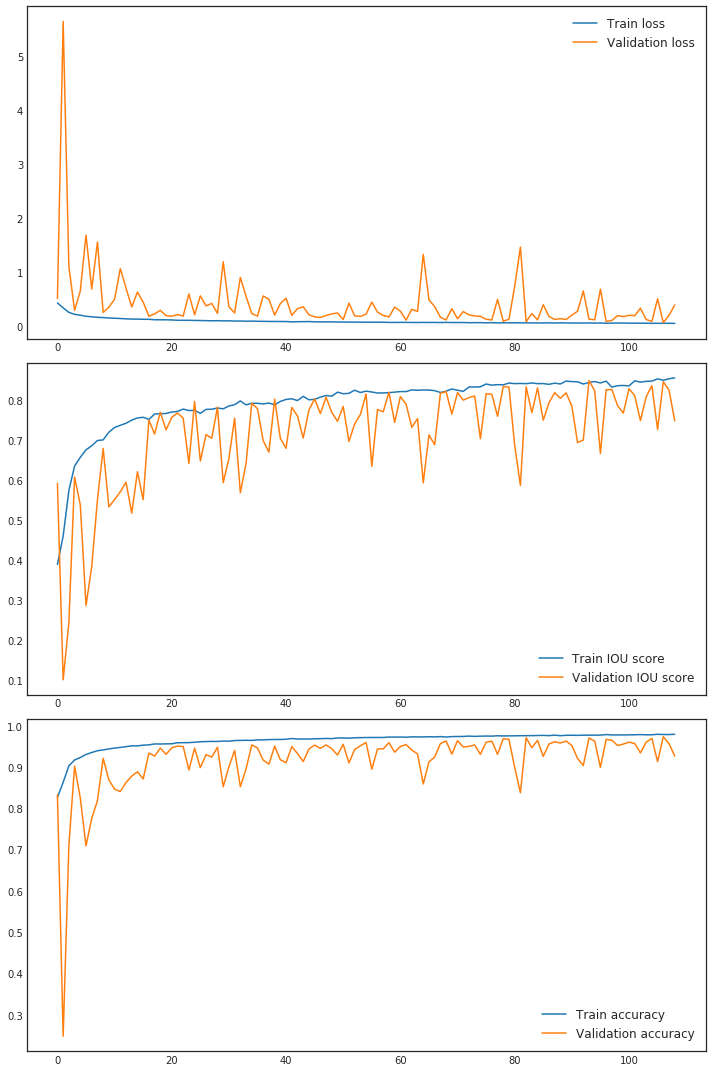

In [58]:
fig, (ax_loss, ax_score, ax_acc) = plt.subplots(3, 1, figsize=(10,15))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend(fontsize='large')

ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train IOU score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation IOU score")
ax_score.legend(fontsize='large')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend(fontsize='large')

plt.tight_layout()
plt.show()


In [94]:
client_data = ((x_train1, y_train1), (x_train2, y_train2), (x_train3, y_train3))

In [70]:
client_fg_percent = [calculate_foreground_percentage(y_train1, 128), calculate_foreground_percentage(y_train2, 128), calculate_foreground_percentage(y_train3, 128)]

In [75]:
total_foreground_percentage = sum(client_fg_percent)
weights = [fp / total_foreground_percentage for fp in client_fg_percent]

In [76]:
weights

[0.45161593135082007, 0.5212999799318532, 0.027084088717326725]

In [97]:
global_model = create_model()
#global_temp_model = create_model()
local_model = create_model()
#global_model.set_weights(model1.get_weights())

In [98]:
import tensorflow as tf
import numpy as np

# - global_model (your Keras model)
# - local_model (a copy of global_model used for local training)
# - client_data (a list of tuples, each tuple containing X and y for a client)
# - x_valid, y_valid (validation data)

# Number of rounds for federated learning
num_rounds = 150
num_clients = 3
globaliou_=[]
localiou_=[]
temp_global_model_weights = []

best_global_iou = 0.0  # Initialize best global IoU

for round_num in range(num_rounds):
    print(f"Round {round_num + 1}/{num_rounds}")

    local_weights = []

    # Train on each client
    for client_id in range(num_clients):
        #print(f"Training on client {client_id + 1}")

        # Create local model and set global weights
        local_model.set_weights(global_model.get_weights())

        # Get client data
        X, y = client_data[client_id]
        #print(f"Training Starts on client {client_id + 1}")
        with tf.device('/GPU:0'):
            # Train local model
            local_model.fit(X, y, epochs=1, batch_size=32, verbose=0)
        loss, iou, accuracy = local_model.evaluate(x_valid, y_valid, verbose=0)
        localiou_.append(iou)
        #print(f"Local model iou after round {round_num + 1}: {iou:.4f}")
        # Collect local model weights
        local_weights.append(local_model.get_weights())

    # Federated averaging: Aggregate local weights
    #averaged_weights = [np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
    #                    for i in range(len(local_weights[0]))]
    num_samples = [len(client_data[i][0]) for i in range(num_clients)]
    total_samples = sum(num_samples)
    
    averaged_weights = [
    np.sum([local_weights[j][i] * (num_samples[j] / total_samples) for j in range(num_clients)], axis=0)
    for i in range(len(local_weights[0]))]
    # Evaluate the global model with the averaged weights
    
    global_model.set_weights(averaged_weights) #update the real model.
    loss, iou, accuracy = global_model.evaluate(x_valid, y_valid, verbose=0)
    globaliou_.append(iou)

    # Check if global IoU is improved
    if iou > best_global_iou:
        #print("Global IOU improved, updating weights")
        temp_global_model_weights =  global_model.get_weights()
        print(f"Global model iou after round {round_num + 1}: {iou:.4f}")
        best_global_iou = iou
    #else:
        
        #print("Global IOU not improved.")

Round 1/150
Global model iou after round 1: 0.5927
Round 2/150
Round 3/150
Round 4/150
Round 5/150
Round 6/150
Round 7/150
Round 8/150
Round 9/150
Round 10/150
Round 11/150
Round 12/150
Round 13/150
Round 14/150
Round 15/150
Round 16/150
Round 17/150
Round 18/150
Round 19/150
Round 20/150
Round 21/150
Round 22/150
Global model iou after round 22: 0.6356
Round 23/150
Global model iou after round 23: 0.6732
Round 24/150
Round 25/150
Round 26/150
Round 27/150
Round 28/150
Round 29/150
Round 30/150
Round 31/150
Round 32/150
Round 33/150
Round 34/150
Round 35/150
Round 36/150
Round 37/150
Round 38/150
Round 39/150
Round 40/150
Round 41/150
Round 42/150
Round 43/150
Round 44/150
Round 45/150
Round 46/150
Round 47/150
Round 48/150
Round 49/150
Round 50/150
Round 51/150
Round 52/150
Global model iou after round 52: 0.7386
Round 53/150
Round 54/150
Round 55/150
Round 56/150
Round 57/150
Round 58/150
Round 59/150
Round 60/150
Round 61/150
Round 62/150
Round 63/150
Round 64/150
Round 65/150
Round

In [77]:
#salt coverage weights

In [ ]:
import tensorflow as tf
import numpy as np

# Assuming you have:
# - global_model (your Keras model)
# - local_model (a copy of global_model used for local training)
# - client_data (a list of tuples, each tuple containing X and y for a client)
# - x_valid, y_valid (validation data)

# Number of rounds for federated learning
num_rounds = 150
num_clients = 3
temp_global_model_weights = []

best_global_iou = 0.0  # Initialize best global IoU

for round_num in range(num_rounds):
    print(f"Round {round_num + 1}/{num_rounds}")

    local_weights = []

    # Train on each client
    for client_id in range(num_clients):
        #print(f"Training on client {client_id + 1}")

        # Create local model and set global weights
        local_model.set_weights(global_model.get_weights())

        # Get client data
        X, y = client_data[client_id]
        #print(f"Training Starts on client {client_id + 1}")
        with tf.device('/GPU:0'):
            # Train local model
            local_model.fit(X, y, epochs=1, batch_size=32, verbose=0)
        #loss, iou, accuracy = local_model.evaluate(x_valid, y_valid, verbose=0)
        #print(f"Local model iou after round {round_num + 1}: {iou:.4f}")
        # Collect local model weights
        local_weights.append(local_model.get_weights())

    # Federated averaging: Aggregate local weights
    #averaged_weights = [np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
    #                    for i in range(len(local_weights[0]))]
    #num_samples = [len(client_data[i][0]) for i in range(num_clients)]
    #total_samples = sum(num_samples)
    
    averaged_weights = [
    np.sum([local_weights[j][i] * weights[j] for j in range(num_clients)], axis=0)
    for i in range(len(local_weights[0]))]
    # Evaluate the global model with the averaged weights
    
    global_model.set_weights(averaged_weights) #update the real model.
    loss, iou, accuracy = global_model.evaluate(x_valid, y_valid, verbose=0)
    

    # Check if global IoU is improved
    if iou > best_global_iou:
        #print("Global IOU improved, updating weights")
        temp_global_model_weights =  global_model.get_weights()
        print(f"Global model iou after round {round_num + 1}: {iou:.4f}")
        best_global_iou = iou
    #else:
        
        #print("Global IOU not improved.")

In [94]:
global_model.set_weights(temp_global_model_weights)
global_model.evaluate(x_valid, y_valid, verbose=0)

[0.20465111966206603, 0.7530136986301369, 0.9494635593401243]

In [95]:
global_model.save('fed_sample_w_avgv2.model')

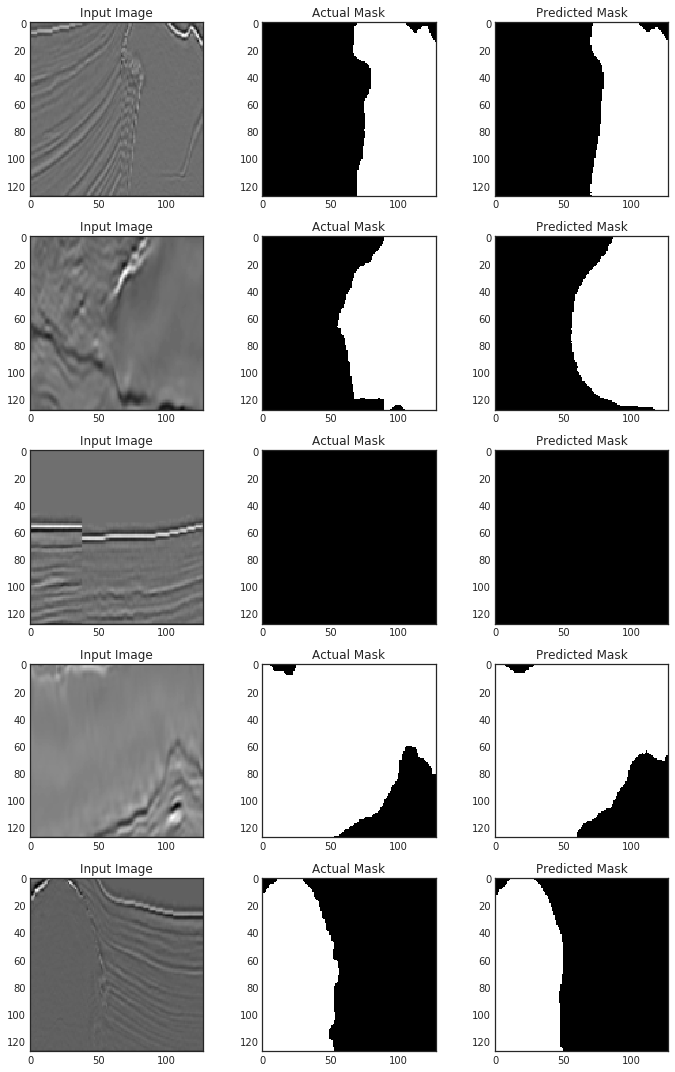

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Predict the masks
predicted_masks = model1.predict(x_valid)

# Ensure binary masks (thresholding)
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.float32)

# Randomly select 5 instances
num_samples = 5
#random_indices = np.random.choice(len(x_valid), num_samples, replace=False)

# Plot actual vs. predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(x_valid[idx].squeeze(),cmap="gray")  # Original image
    axes[i, 0].set_title("Input Image")
    #axes[i, 0].axis("off")

    axes[i, 1].imshow(y_valid[idx].squeeze(), cmap="gray")  # Actual mask
    axes[i, 1].set_title("Actual Mask")
    #axes[i, 1].axis("off")

    axes[i, 2].imshow(predicted_masks[idx].squeeze(), cmap="gray")  # Predicted mask
    axes[i, 2].set_title("Predicted Mask")
    #axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
